<a href="https://colab.research.google.com/github/dldisha/TSS21_Machine_Learning/blob/main/HW3_Model_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Model Order Selection for Neural Data



**Name**:

**Net ID**:

**Attribution**: This notebook is a slightly adapted version of the [model order selection lab assignment](https://github.com/sdrangan/introml/blob/master/unit04_model_sel/lab_neural_partial.ipynb) by Prof. Sundeep Rangan.

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain.  In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces.  In this notebook, you will use model selection for performing some simple analysis on real neural signals.  

## Loading the data

The data in this lab comes from neural recordings described in:

<a href="http://jn.physiology.org/content/106/2/764.short">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain.  Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls.  These spikes trigger the electro-chemical signals between one neuron and another.  In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain.  During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.  

The goal of the experiment is to try to *read the monkey's brain*:  That is, predict the hand motion from the neural signals from the motor cortex.

We first load the key packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold

The full data is available on the CRCNS website  http://crcns.org/data-sets/movements/dream.  However, the raw data files can be quite large.  To make the lab easier, the [Kording lab](http://kordinglab.com/) at UPenn has put together an excellent [repository](https://github.com/KordingLab/Neural_Decoding) where they have created simple pre-processed versions of the data.  You can download the file `example_data_s1.pickle` from the [Dropbox link](https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=0).  Alternatively, you can directly run the following command.  This may take a little while to download since the file is 26 MB.

In [2]:
!wget 'https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=1' -O example_data_s1.pickle

--2021-10-09 19:36:15--  https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle [following]
--2021-10-09 19:36:15--  https://www.dropbox.com/sh/dl/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce18634de199c07b886517783b0.dl.dropboxusercontent.com/cd/0/get/BXuZNMcN9NtHKgLQac3iQfBpiEH_pAUGastxMAObokDM171iKU-0hUmdY3yCeXcrEBtFZX5JocRAr2a_UlhuUlhJxJxHcvJZmW0DFaN0iEcVXPaFIwfKwlf8wBXClYnKh2BuqfYLtBf-crEo7AWhZcXS/file?dl=1# [following]
--2021-10-09 19:36:16--  https://uce18634de199c07b886517783b0.dl.dropboxus

The file is a *pickle* data structure, which uses the Python package `pickle` to serialize Python objects into data files.  Once you have downloaded the file, you can run the following command to retrieve the data from the pickle file.

In [3]:
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)

The matrix `X` is matrix of spike counts from different neurons, where `X[i,j]` is the number of spikes from neuron `j` in time bin `i`.

The matrix `y` has two columns:
* `y[i,0] = ` velocity of the monkey's hand in the x-direction in time bin `i`
* `y[i,1] = ` velocity of the monkey's hand in the y-direction in time bin `i`

Our goal will be to predict `y` from `X`.  

Each time bin represent `tsamp=0.05` seconds of time.  Using `X.shape` and `y.shape`, we can compute and print:
* `nt = ` the total number of time bins
* `nneuron = ` the total number of neurons
* `nout = ` the total number of output variables to track = number of columns in `y`
* `ttotal = ` total time of the experiment is seconds. 

In [4]:
tsamp = 0.05  # sampling time in seconds

nt, nneuron = X.shape
nout = y.shape[1]
ttotal = nt*tsamp

print('Number of neurons = %d' % nneuron)
print('Number of time samples = %d' % nt)
print('Number of outputs = %d' % nout)
print('Total time (secs) = %f' % ttotal)

Number of neurons = 52
Number of time samples = 61339
Number of outputs = 2
Total time (secs) = 3066.950000


Then, we can plot the velocity against time, for each direction, for the first 1000 samples:

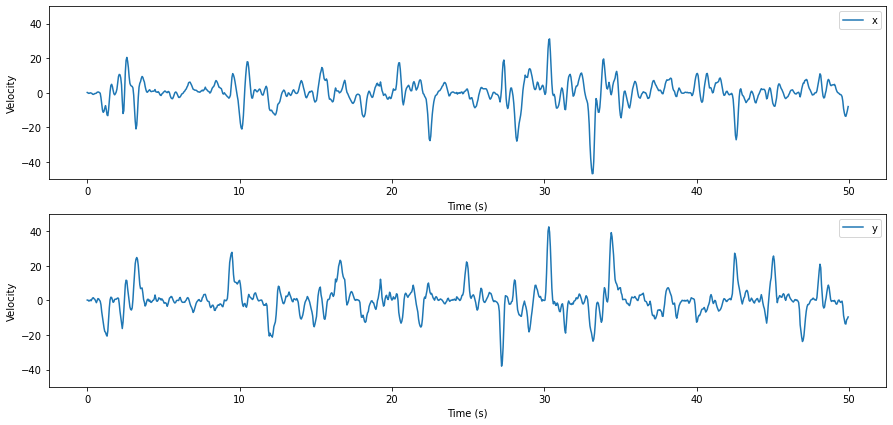

In [5]:
t_cutoff = 1000
directions = ['x', 'y']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,7))
for n in range(nout):
  sns.lineplot(x=np.arange(0, t_cutoff)*tsamp, y=y[0:t_cutoff, n], label=directions[n], ax=axes[n]);

  axes[n].set_ylabel("Velocity")
  axes[n].set_xlabel("Time (s)")
  axes[n].set_ylim(-50,50)

We can also "zoom in" on a small slice of time in which the monkey is moving the hand, and see the neural activity at the same time.

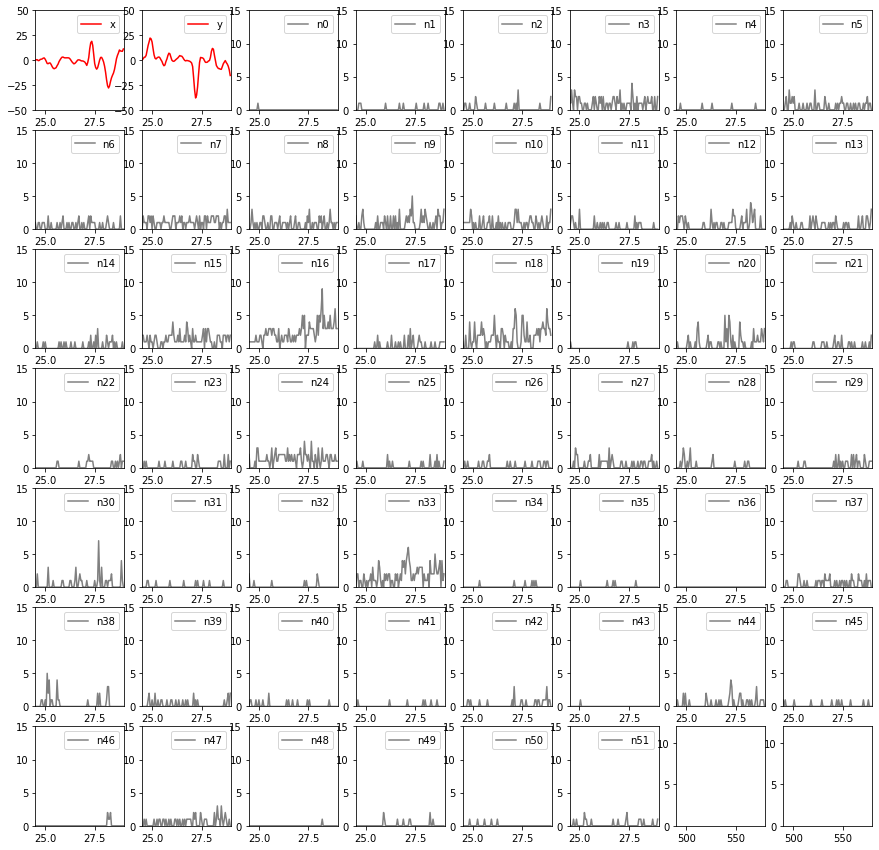

In [6]:
t_start = 490
t_end = 580

fig, axes = plt.subplots(nrows=7, ncols=8, figsize=(15,15))

# Setting the range for all axes
plt.setp(axes, xlim=(t_start, t_end), ylim=(0,12));

for n in range(nout):
  sns.lineplot(x=np.arange(t_start, t_end)*tsamp, y=y[t_start:t_end, n], ax=axes[n//2,n%2], color='red', label=directions[n])
  plt.setp(axes[n//2,n%2], xlim=(t_start*tsamp, t_end*tsamp), ylim=(-50, +50));

for n in range(nneuron):
  sns.lineplot(x=np.arange(t_start, t_end)*tsamp, y=X[t_start:t_end, n], ax=axes[(n+2)//8,(n+2)%8], label="n%d" % n, color='grey')
  plt.setp(axes[(n+2)//8,(n+2)%8], xlim=(t_start*tsamp, t_end*tsamp), ylim=(0, +15));



## Fitting a linear model

Let's first try a linear regression model to fit the data.

To start, we will split the data into a training set and a test set. We'll fit the model on the training set and then use the test set to estimate the model performance on new, unseen data.

**To shuffle or not to shuffle?**

The `train_test_split` function has an optional `shuffle` argument. 


*   If you use `shuffle=False`, then `train_test_split` will take the first part of the data as the training set and the second part of the data as the test set, according to the ratio you specify in `test_size` or `train_size`.
*   If you use `shuffle=True`, then `train_test_split` will first randomly shuffle the data. Then, it will take the first part of the *shuffled* data as the training set and the second part of the *shuffled* data as the test set, according to the ratio you specify in `test_size` or `train_size`.

According to the function [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), by default, `shuffle` is `True`: 

> **shuffle: bool, default=True**
> 
> Whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

so if you do not specify anything related to `shuffle`, your data will be randomly shuffled before it is split into training and test data.

Under what conditions should you shuffle data? Suppose your dataset includes samples of a medical experiment on 1000 subjects, and the first 500 samples in the data are from male subjects while the second 500 samples are from female subjects. If you set `shuffle=False`, then your training set would have a much higher proportion of male subjects than your test set (with the specific numbers depending on the ratio you specify).

On the other hand, suppose your dataset includes stock prices at closing time, with each sample representing a different date (in order). If you allow `train_test_split` to shuffle the data, then your model will be allowed to "learn" stock prices using prices from the day *after* the one it is trying to predict! Obviously, your model won't be able to learn from future dates in production, so it shouldn't be allowed to in the evaluation stage, either. (Predicting the past using the future is considered a type of data leakage.)

With this in mind, it is usually inappropriate to shuffle time series data when splitting it up into smaller sets for training, validation, or testing. 

(There are more sophisticated ways to handle splitting time series data, but for now, splitting it up the usual way, just without shuffling first, will suffice.)


Given the discussion above, use the `train_test_split` function to split the data into training and test sets, but with no shuffling.  Let `Xtr,ytr` be the training data set and `Xts,yts` be the test data set.  Use `test_size=0.33` so 1/3 of the data is used for evaluating the model performance.

In [7]:
# TODO 1
#Matrix X splitting up the data
Xtr, Xts = train_test_split(X, test_size = 0.33, shuffle=False)

#Matrix y splitting up the data
ytr, yts = train_test_split(y, test_size = 0.33, shuffle=False)

Now, fit a linear regression on the training data `Xtr,ytr`.  Make a prediction  `yhat` using the test data, `Xts`.  Compare `yhat` to `yts` to measure `rsq`, the  R2 value.  You can use the sklearn `r2_score` method. Print the `rsq` value.  You should get `rsq` of around `0.45`. 

In [8]:
# TODO 2
#Fitting linear regression model
reg_Xytr = LinearRegression().fit(Xtr, ytr)
print("Intercept: " , reg_Xytr.intercept_)

#Predicting yhat using Xts
yhat = reg_Xytr.predict(Xts)

#rsq
rsq = r2_score(yts, yhat)
print("R square: ", rsq)


Intercept:  [-0.35795412  4.14701907]
R square:  0.4499831346553009


It is useful to plot the predicted vs. actual values. Since we have two predicted values for each sample - the velocity in the X direction and the velocity in the Y direction - you should make two subplots, 

* one of predicted X direction vs. actual X direction,
* one of predicted Y direction vs. actual Y direction 

Make sure to carefully label each axis.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Predicted Velocity $\\hat y _i$')

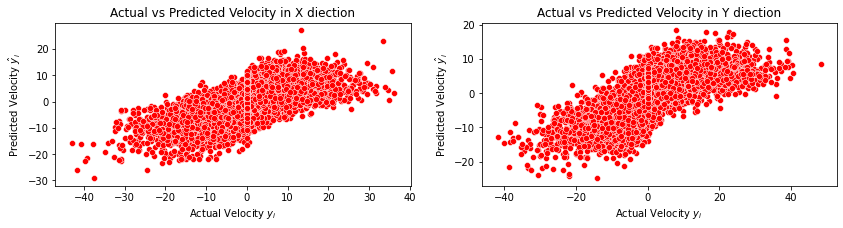

In [9]:
# TODO 3A
fig = plt.figure(figsize=(14,3))

#in X direction
plt.subplot(1,2,1)
sns.scatterplot(yts[:,0], yhat[:,0], color="red")
plt.title('Actual vs Predicted Velocity in X diection')
plt.xlabel('Actual Velocity $y _i$')
plt.ylabel('Predicted Velocity $\hat y _i$')

#in Y direction
plt.subplot(1,2,2)
sns.scatterplot(yts[:,1], yhat[:,1], color="red")
plt.title('Actual vs Predicted Velocity in Y diection')
plt.xlabel('Actual Velocity $y _i$')
plt.ylabel('Predicted Velocity $\hat y _i$')

It can also be useful to visualize the actual and predicted values over time, for a slice of time. Create two subplots, both with time on the horizontal axis, but only including *the first 1000 rows* in the data. On the vertical axis, 

* for one subplot: show the actual X direction as a line of one color, and the predicted X direction as a line of another color.
* for the second subplot: show the actual Y direction as a line of one color, and the predicted Y direction as a line of another color.

Make sure to carefully label each axis (including units on the time axis!), and label the data series (i.e. which color is the actual value and which is the predicted value).

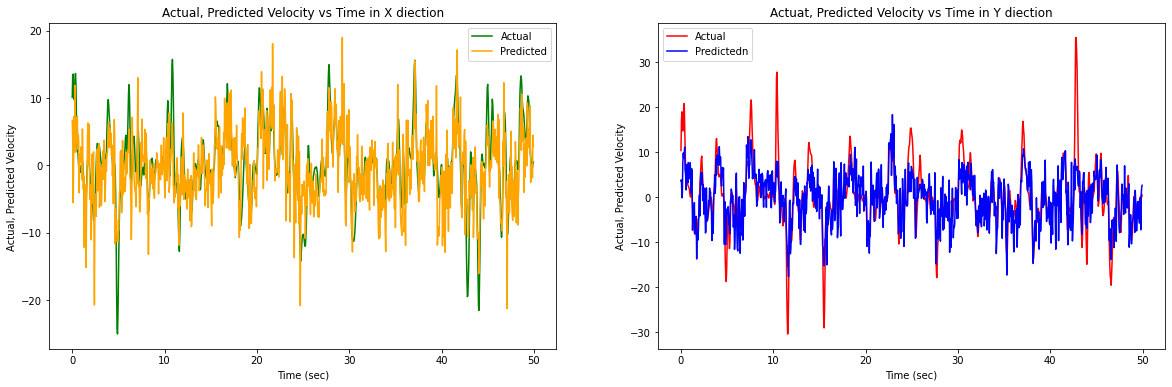

In [10]:
# TODO 3B
t_cutoff = 1000
fig = plt.figure(figsize=(20,6))

#in X direction
plt.subplot(1,2,1)
sns.lineplot(x=np.arange(0, t_cutoff)*tsamp, y=yts[0:t_cutoff, 0], color="green", label="Actual");
sns.lineplot(x=np.arange(0, t_cutoff)*tsamp, y=yhat[0:t_cutoff, 0], color="orange", label="Predicted");
plt.title('Actual, Predicted Velocity vs Time in X diection')
plt.xlabel('Time (sec)')
plt.ylabel('Actual, Predicted Velocity ')
plt.legend()

#in Y direction
plt.subplot(1,2,2)
sns.lineplot(x=np.arange(0, t_cutoff)*tsamp, y=yts[0:t_cutoff, 1], color="red", label="Actual");
sns.lineplot(x=np.arange(0, t_cutoff)*tsamp, y=yhat[0:t_cutoff, 1], color="blue", label="Predictedn");
plt.title('Actuat, Predicted Velocity vs Time in Y diection')
plt.xlabel('Time (sec)')
plt.ylabel('Actual, Predicted Velocity')
plt.legend()




Comment on this plot - does the model predict the hand velocity well?

**Answer:** No, the model isn't doing a good job in predicting the velocities. I can say this because there are number of times when the actual velocity was at peak in the Y direction but the predicted value wasn't even close to the actual value. In the X direction, the model performed a little better but this isn't helpful. 

For a model to predict values well to some extent we want both the directions to have their actual and predicted values to be same or close to some extent. 

## Fitting a model with delay



One way we can improve the model accuracy is to add features using delayed version of the existing features.  

Specifically, the model we used above tries to predict velocity in direction $k$ at time $i$ using

$$\hat{y}_{i,k} = w_{k,0} + \sum_{d=1}^{\text{nneuron}} w_{k,d} X_{i,d}  $$

In this model, $\hat{y}_{i,k}$ at the $i$th time bin was only dependent on  $X_i$, the number of spikes of each neuron in time bin $i$.  In signal processing, this is called a *memoryless* model.  

However, in many physical systems, such as those that arise in neuroscience, there is a delay between the inputs and outputs.  To model this effect, we could add additional features to each row of data, representing the number of spikes of each neuron in the *previous* row. Then, the output at time $i$ would be modeled as the effect of the neurons firing in time $i$ _and_ the effect of the neurons firing in time $i-1$. 

We wouldn't be able to use data from the past for the first row of data, since we don't _have_ data about neurons firing in the previous time step. But we can drop that row. If our original data matrix had `nt` rows and `nneuron` columns, our data matrix with delayed features would have `nt - 1` rows and `nneuron + 1 x nneuron` columns. (The first `nneuron` columns represent the number of spikes in each neuron for the current time, the next `nneuron` columns represent the number of spikes in each neuron for the previous time.)

Furthermore, we can "look back" any number of time steps, so that the output at time $i$ is modeled as the effect of the neurons firing in time $i$, the neurons firing in time $i-1$, ..., all the way up to the effect of the neurons firing in time $i- \text{dly}$ (where $\text{dly}$ is the maximum number of time steps we're going to "look back" on). Our data matrix with the additional delayed features would have `nt - dly` rows and `nneuron + dly x nneuron` columns.


Here is a function that accepts `X` and `y` data and a `dly` argument, and returns `X` and `y` with delayed features up to `dly` time steps backward.

In [11]:
def create_dly_data(X,y,dly):
    """
    Create delayed data
    """    
    n,p = X.shape
    Xdly = np.zeros((n-dly,(dly+1)*p))
    for i in range(dly+1):
        Xdly[:,i*p:(i+1)*p] = X[dly-i:n-i,:]
    ydly = y[dly:]
    
    return Xdly, ydly


To convince yourself that this works, try creating a data matrix that includes delayed features one time step back:

In [12]:
X_dly1, y_dly1 = create_dly_data(X, y, 1)

Verify that the dimensions have changed, as expected:

In [13]:
# dimensions of original data matrix
X.shape

(61339, 52)

In [14]:
# dimensions of data matrix with delayed features 1 time step back
X_dly1.shape

(61338, 104)

Check row 0 in the matrix with delayed features, and verify that it is the concatenation of row 1 and row 0 in the original data matrix. (Note that row 0 in the matrix with delayed features corresponds to row 1 in the original data matrix.)

In [15]:
X_dly1[0]

array([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 2., 0., 0., 1., 0., 2., 0., 0., 3., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1.])

In [16]:
np.hstack((X[1], X[0]))

array([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 2., 0., 0., 1., 0., 2., 0., 0., 3., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1.])

In [17]:
y_dly1[0]

array([-0.13949835,  0.11006426])

In [18]:
y[1]

array([-0.13949835,  0.11006426])

Now fit an linear delayed model with `dly=2` delay lags.  That is,
* Create delayed data `Xdly,ydly=create_dly_data(X,y,dly=2)`
* Split the data into training and test as before (again, do not shuffle the data)
* Fit the model on the training data
* Measure the R2 score on the test data

If you did this correctly, you should get a new R2 score around 0.60.  This is significantly better than the memoryless model.

In [19]:
# TODO 4

# Create the delayed data
X_dly1, y_dly1 = create_dly_data(X, y, dly=2)

# Split into training and test
X_dly1_tr, X_dly1_ts = train_test_split(X_dly1, test_size = 0.33, shuffle=False)
y_dly1_tr, y_dly1_ts = train_test_split(y_dly1, test_size = 0.33, shuffle=False)

# Create linear regression object
reg_Xy_dly1_tr = LinearRegression().fit(X_dly1_tr, y_dly1_tr)
print("Intercept: " , reg_Xy_dly1_tr.intercept_)

# Fit the model
yhat_dly1 = reg_Xy_dly1_tr.predict(X_dly1_ts)

# Measure the new r2 score
rsq_dly1 = r2_score(y_dly1_ts, yhat_dly1)
print("R square:", rsq_dly1)

Intercept:  [-0.73744808  3.71152432]
R square: 0.6033897697058304


Plot the predicted vs. true values as before, with one subplot for X velocity and one plot for Y velocity.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Predicted Velocity $\\hat y _i$')

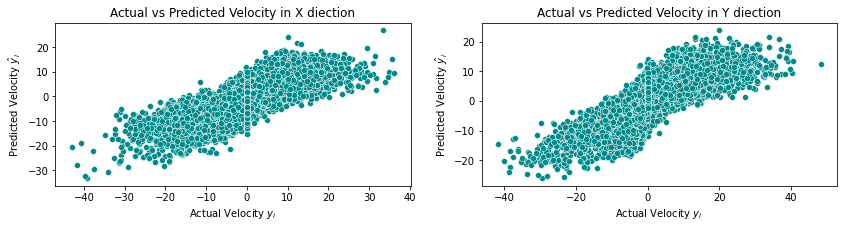

In [20]:
# TODO 5A
fig = plt.figure(figsize=(14,3))

#in X direction
plt.subplot(1,2,1)
sns.scatterplot(y_dly1_ts[:,0], yhat_dly1[:,0], color="darkcyan")
plt.title('Actual vs Predicted Velocity in X diection')
plt.xlabel('Actual Velocity $y _i$')
plt.ylabel('Predicted Velocity $\hat y _i$')

#in Y direction
plt.subplot(1,2,2)
sns.scatterplot(y_dly1_ts[:,1], yhat_dly1[:,1], color="darkcyan")
plt.title('Actual vs Predicted Velocity in Y diection')
plt.xlabel('Actual Velocity $y _i$')
plt.ylabel('Predicted Velocity $\hat y _i$')


Also plot the actual and predicted values over time for the first 1000 samples, as you did before. Comment on this plot - does the model predict the hand velocity well?

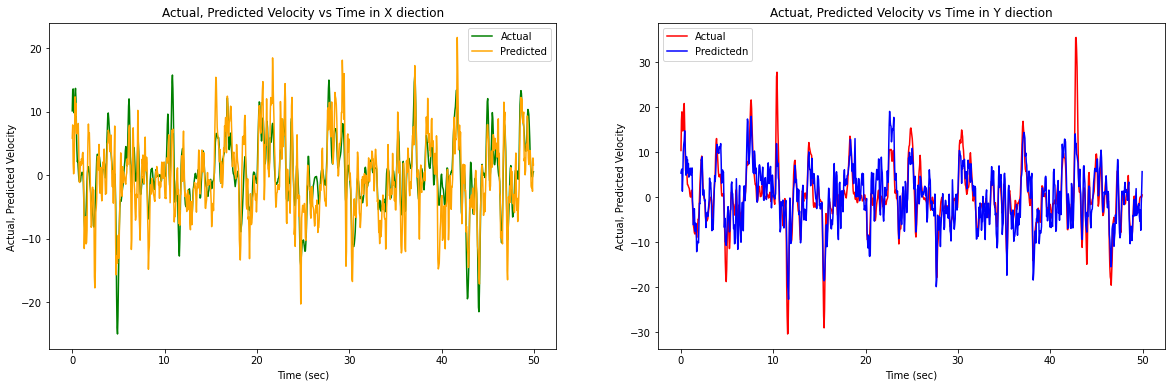

In [21]:
# TODO 5B
t_cutoff = 1000
fig = plt.figure(figsize=(20,6))

#in X direction
plt.subplot(1,2,1)
sns.lineplot(x=np.arange(0, t_cutoff)*tsamp, y=y_dly1_ts[0:t_cutoff, 0], color="green", label="Actual");
sns.lineplot(x=np.arange(0, t_cutoff)*tsamp, y=yhat_dly1[0:t_cutoff, 0], color="orange", label="Predicted");
plt.title('Actual, Predicted Velocity vs Time in X diection')
plt.xlabel('Time (sec)')
plt.ylabel('Actual, Predicted Velocity ')
plt.legend()

#in Y direction
plt.subplot(1,2,2)
sns.lineplot(x=np.arange(0, t_cutoff)*tsamp, y=y_dly1_ts[0:t_cutoff, 1], color="red", label="Actual");
sns.lineplot(x=np.arange(0, t_cutoff)*tsamp, y=yhat_dly1[0:t_cutoff, 1], color="blue", label="Predictedn");
plt.title('Actuat, Predicted Velocity vs Time in Y diection')
plt.xlabel('Time (sec)')
plt.ylabel('Actual, Predicted Velocity')
plt.legend()

**From the plot with delay=2 :**

Yes, after adding a delay of 2 to the model, it is performing better.
We can see how the R2 value changed from 44% to 60%. And how some of the actual peak values which were missed terribly by the predicted values in the previous model are now being achieved to an extent. 

This all shows us that there is some scope in improving the model further. 

## Selecting the optimal delay with K-fold CV

In the previous example, we fixed `dly=2`.  We can now select the optimal delay using K-fold cross validation.  

Since we have a large number of data samples, it turns out that the optimal model order uses a very high delay.  Using the above fitting method, the computations take too long.  So, to simplify things, we will first just pretent that we have a very limited data set.

We will  compute `Xred` and `yred` by taking the first `nred=6000` samples of the data `X` and `y`.  This is about 10% of the overall data.

In [22]:
nred = 6000

Xred = X[:nred]
yred = y[:nred]

We will look at model orders up to `dmax=15`.  We will create a delayed data matrix, `Xdly,ydly`, using `create_dly_data` with the reduced data `Xred,yred` and `dly=dmax`.

In [23]:
dmax = 15

Xdly, ydly = create_dly_data(Xred,yred,dmax)

In [24]:
Xdly.shape

(5985, 832)

In [25]:
ydly.shape

(5985, 2)

Note that we can use `Xdly, ydly` to get a data matrix for any delay _up to_ `dmax`, not only for delay = `dmax`. For example, to get a data matrix with delay = 1:

In [26]:
dtest = 1
X_dtest = Xdly[:,:(dtest+1)*nneuron]
X_dtest.shape

(5985, 104)

We are going to use K-fold CV with `nfold=10` to find the optimal delay, for all the values of delay in `dtest_list`:

In [27]:
dtest_list = np.arange(0, dmax+1)
nd = len(dtest_list)

print(dtest_list)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


You can refer to the example in the "Model order selection" section of the demo notebook. But, make sure to use `shuffle=False` in your `KFold` object, since for this example it would be inappropriate to shuffle the data.

In [28]:
# Number of folds
nfold = 10
 
# TODO 6  Create a k-fold object
kf = KFold(n_splits=nfold, shuffle=False)
 
# TODO 7
# Initialize a matrix Rsq to hold values of the R^2 across the model orders and folds.
dtest_list = np.arange(1,10)
nd = len(dtest_list)
Mse = np.zeros((nd,nfold))
Rsq  = np.zeros((nd,nfold))
 
# Loop over the folds
for i, idx_split in enumerate(kf.split(Xdly)):
    
    # Get the training and validation data in the split
    idx_tr, idx_val = idx_split  
      
    for it, dtest in enumerate(dtest_list):
        # TODO 8 
        # don't call create_dly_data again
        # just select the appropriate subset of columns of Xdly
        # X_dtest = Xdly with the columns corresponding to only the `dtest+1` most recent times.
        X_dtest = Xdly[:,:(dtest+1)*nneuron]

        # TODO 9
        # Split the data (X_dtest,ydly) into training and validation
        # using idx_tr and idx_val
        Xtr = X_dtest[idx_tr]
        ytr = ydly[idx_tr]
        Xval = X_dtest[idx_val]
        yval = ydly[idx_val]
   
        # TODO 10  Fit linear regression on training data
        reg_dtest = LinearRegression().fit(Xtr, ytr)
 
        # TODO 11  Measure the R2 on validation data and store in the matrix Rsq
        yhat_dtest = reg_dtest.predict(Xval)
        Mse[it, i] = metrics.mean_squared_error(yval, yhat_dtest)
        Rsq[it, i] = metrics.r2_score(yval, yhat_dtest)


Compute the mean and standard error of the R2 values for each model (each delay value) and plot it as a function of the delay. Use a `plt.errorbar` plot, as shown in the "Model selection using 1-SE rule" section of the demo notebook.  Label your axes.

In [29]:
# TODO 12
i = 0
while i < 9:
  print("Delay Value",i+1,", Mean: " , np.mean(Rsq[i]))
  print("Dealy value",i+1,", Standard Error: ", np.std(Rsq[i])/np.sqrt(np.size(Rsq[i])), "\n")
  i = i + 1

#print(Rsq.mean(axis=1))
print("Total R2 mean:", np.mean(Rsq))
print("Total R2 Standard Error: ", np.std(Rsq)/np.sqrt(np.size(Rsq)))

Delay Value 1 , Mean:  0.5523706879623804
Dealy value 1 , Standard Error:  0.007401657458778376 

Delay Value 2 , Mean:  0.5971964733334623
Dealy value 2 , Standard Error:  0.006474749064932194 

Delay Value 3 , Mean:  0.6203491244358783
Dealy value 3 , Standard Error:  0.00707574461602442 

Delay Value 4 , Mean:  0.6369071007654364
Dealy value 4 , Standard Error:  0.007734369471985448 

Delay Value 5 , Mean:  0.649843148651065
Dealy value 5 , Standard Error:  0.008152547824145026 

Delay Value 6 , Mean:  0.6583958027745348
Dealy value 6 , Standard Error:  0.008223454200375771 

Delay Value 7 , Mean:  0.6628451037633811
Dealy value 7 , Standard Error:  0.008164257774562244 

Delay Value 8 , Mean:  0.6653604455122528
Dealy value 8 , Standard Error:  0.007770691757201875 

Delay Value 9 , Mean:  0.6652636718941168
Dealy value 9 , Standard Error:  0.007579721257003987 

Total R2 mean: 0.6342812843436119
Total R2 Standard Error:  0.00459505397798348


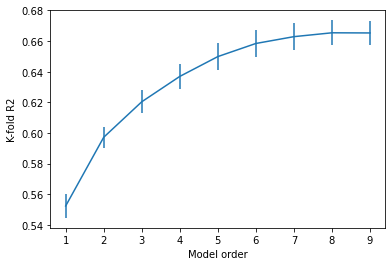

In [30]:
plt.errorbar(x=dtest_list, y=Rsq.mean(axis=1), yerr=Rsq.std(axis=1)/np.sqrt(nfold-1));

plt.xlabel("Model order");
plt.ylabel("K-fold R2");

Write code to find the delay that has the best validation R2. Print the best delay according to the "best R2" rule.

In [31]:
# TODO 13
idx_max = np.argmax(Rsq.mean(axis=1))
d_max_r2 = dtest_list[idx_max]
d_max_r2


8

Now write code to find the best delay using the one SE rule (i.e. find the simplest model whose validation R2 is within one SE of the model with the best R2). Print the best delay according to the "one SE rule."

In [32]:
# TODO 14
idx_max = np.argmax(Rsq.mean(axis=1))
target = Rsq[idx_max,:].mean() - Rsq[idx_max,:].std()/np.sqrt(nfold-1)
# np.where returns indices of values where condition is satisfied
idx_one_se_r2 = np.where(Rsq.mean(axis=1) > target)
d_one_se_r2 = np.min(dtest_list[idx_one_se_r2])
d_one_se_r2

6

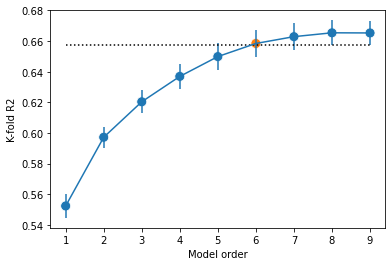

In [34]:
plt.errorbar(x=dtest_list, y=Rsq.mean(axis=1), yerr=Rsq.std(axis=1)/np.sqrt(nfold-1));
plt.hlines(y=target, xmin=np.min(dtest_list), xmax=np.max(dtest_list), ls='dotted')
sns.scatterplot(x=dtest_list, y=Rsq.mean(axis=1), hue=dtest_list==d_one_se_r2, s=100, legend=False);

plt.xlabel("Model order");
plt.ylabel("K-fold R2");

## Fitting the selected model

Now that we have selected a model order, we can fit the (reduced) data to that model.

Use your `Xdly` and `ydly` to fit a linear regression model using the best delay according to the one SE rule. 

In [35]:
# TODO 15
best_dly = 6
X_se_dtest = Xdly[:,:(best_dly+1)*nneuron]
y_se_dtest = ydly[:,:(best_dly+1)*nneuron]
reg_se = LinearRegression().fit(X_se_dtest, y_se_dtest)

Then, define a test set using data that was not used to train the model:

In [36]:
# TODO 16
# if dopt_one_se is the optimal model order, you can use
Xts = X[nred+1:nred+1001+6]
yts = y[nred+1:nred+1001+6]
# and then use 
Xts_dly, yts_dly = create_dly_data(Xts,yts,6)

Use your fitted model to find the R2 score on the test set.

In [37]:
# TODO 17
yhat_se = reg_se.predict(Xts_dly)
rsq_se = r2_score(yts_dly, yhat_se)
print("R square:", rsq_se)

R square: 0.6949084442568592


Also plot the actual and predicted values over time for the first 1000 samples of the *test* data (similar to your plots in the previous sections). Comment on this plot - does the model predict the hand velocity well?

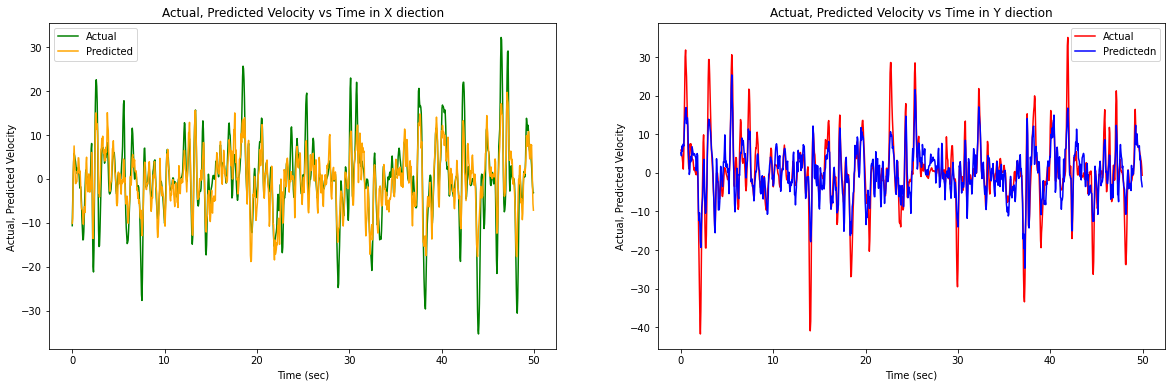

In [38]:
# TODO 18
fig = plt.figure(figsize=(20,6))

#in X direction
plt.subplot(1,2,1)
sns.lineplot(x=np.arange(0, t_cutoff)*tsamp, y=yts_dly[0:t_cutoff, 0], color="green", label="Actual");
sns.lineplot(x=np.arange(0, t_cutoff)*tsamp, y=yhat_se[0:t_cutoff, 0], color="orange", label="Predicted");
plt.title('Actual, Predicted Velocity vs Time in X diection')
plt.xlabel('Time (sec)')
plt.ylabel('Actual, Predicted Velocity ')
plt.legend()

#in Y direction
plt.subplot(1,2,2)
sns.lineplot(x=np.arange(0, t_cutoff)*tsamp, y=yts_dly[0:t_cutoff, 1], color="red", label="Actual");
sns.lineplot(x=np.arange(0, t_cutoff)*tsamp, y=yhat_se[0:t_cutoff, 1], color="blue", label="Predictedn");
plt.title('Actuat, Predicted Velocity vs Time in Y diection')
plt.xlabel('Time (sec)')
plt.ylabel('Actual, Predicted Velocity')
plt.legend()

**Comment on the above model plot after K-fold cross-validation:**

Yes, the model predicts the hand velocity well. We can see how R2 value changes from 44% when a linear model was fitted, 60% when a model was fitted with a delay of 2 and then finally to 69% with K-fold Cross Validation.